- By: Harkishan Singh Baniya
- Email: harkishansinghbaniya@gmail.com
- Reference: Advances in Financial Machine Learning by Dr Marcos Lopez De Prado

This notebook is a part of article series **Alternative Bars on Alpaca** . In first part of the article I have explained how to generate *Alternative Bars*  i.e. `tick bar`, `volume bar` and `dollar bar` using Alpaca API. In this second part we will explore them and look at some of there statistical properties. <br>

The analysis will be performed on historical bars of SPY (Spyder ETF) trades data from *Jan 1st 2015* to *Dec 31st 2019*. The sampling freqency/ thresholds of different bars are as follows.

- Tick Bars: 10,000 (ticks)
- Volume Bars: 1,000,000 (volume/qty)
- Dollar Bars: 100,000,000 (dollar)
- Time Bars (1): 1 (hour)
- Time Bars (2): 1 (day)


In [1]:
#Imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style 

from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf

style.use('ggplot')

%matplotlib inline

In [2]:
#read data and store the bars in a dictionary
def read_data(symbol:str):
    bars = {}
    bars['time_bar_5m'] = pd.read_csv(f'sample_datasets/analysis/{symbol}_5minute_bars.csv', index_col=[0], parse_dates=True)
    bars['tick_bar'] = pd.read_csv(f'sample_datasets/analysis/{symbol}_tick_bars.csv', index_col=[0], parse_dates=True)
    bars['volume_bar'] = pd.read_csv(f'sample_datasets/analysis/{symbol}_volume_bars.csv', index_col=[0], parse_dates=True)
    bars['dollar_bar'] = pd.read_csv(f'sample_datasets/analysis/{symbol}_dollar_bars.csv', index_col=[0], parse_dates=True)
    return bars
AAPL = read_data(symbol='AAPL')

## Bar Count

In [3]:
#Bar Count Analysis and Plots
def show_bar_count(bars:dict, time_group='1D'):
    counts = {}
    f,ax=plt.subplots(figsize=(16,9))
    for bar in bars.keys():
        if bar != 'time_bar_5m':
            df = bars[bar]
            count = df.groupby(pd.Grouper(freq=time_group))['close'].count()
            counts[bar] = count
            count.plot(ax=ax, ls='-', label=bar, alpha=0.8)
            print(f'The bar count for {bar} with time group {time_group} has a mean count of {count.mean()} and a standard deviation of {count.std()}')
    ax.legend()

The bar count for tick_bar with time group 1D has a mean count of 30.27434842249657 and a standard deviation of 25.595252240338773
The bar count for volume_bar with time group 1D has a mean count of 28.194787379972563 and a standard deviation of 23.5706309444813
The bar count for dollar_bar with time group 1D has a mean count of 25.8079561042524 and a standard deviation of 21.11471525618375


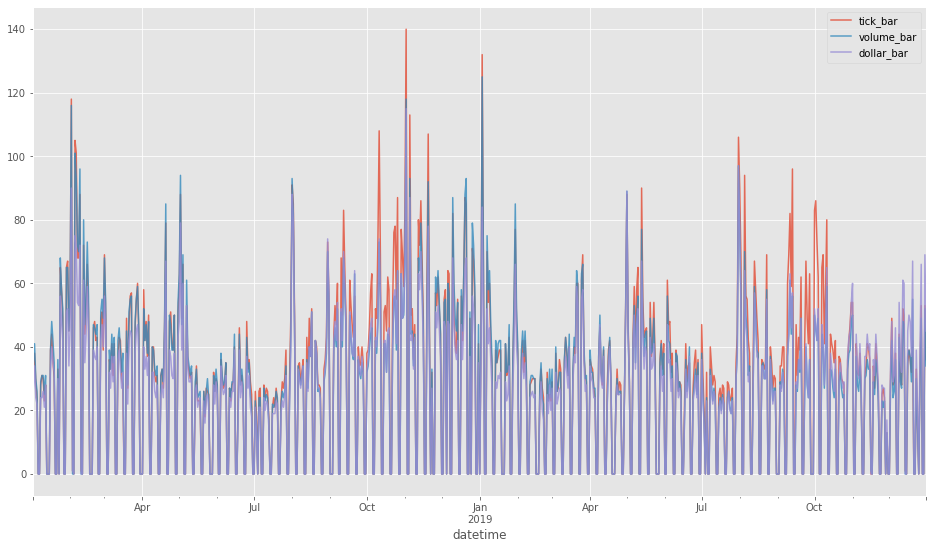

In [4]:
show_bar_count(AAPL)

Bars are sample with threholds chossen arbitarily that gives a bar count between 25-30 bars per day. Overall bar counts are most stable for dollar bars since it has the least deviation from the mean count, while tick bars has a high deviation. 

## Comparing with Time Bars Sampling

In [5]:
def plot_bars(bars:dict, date:str='2019-08-07'):
    time_bar = bars['time_bar_5m'].close.loc[date]
    tick_bar = bars['tick_bar'].close.loc[date]
    volume_bar = bars['volume_bar'].close.loc[date]
    dollar_bar = bars['dollar_bar'].close.loc[date]
    
    fig, (ax1, ax2, ax3)= plt.subplots(3, figsize=(12,9))
  
    
    time_bar.plot(ax=ax1, label='time bar', ls='', marker='|', color='red')
    tick_bar.plot(ax=ax1, label='tick bar', ls='', marker='D', color='yellow', alpha=0.4)
    ax1.legend()
    time_bar.plot(ax=ax2, label='time bar', ls='', marker='|', color='red')
    volume_bar.plot(ax=ax2, label='volume bar', ls='', marker='o', color='purple', alpha=0.4)
    ax2.legend()
    time_bar.plot(ax=ax3, label='time bar', ls='', marker='|', color='red')
    dollar_bar.plot(ax=ax3, label='dollar bar', ls='', marker='*', color='blue', alpha=0.4)
    ax3.legend() 


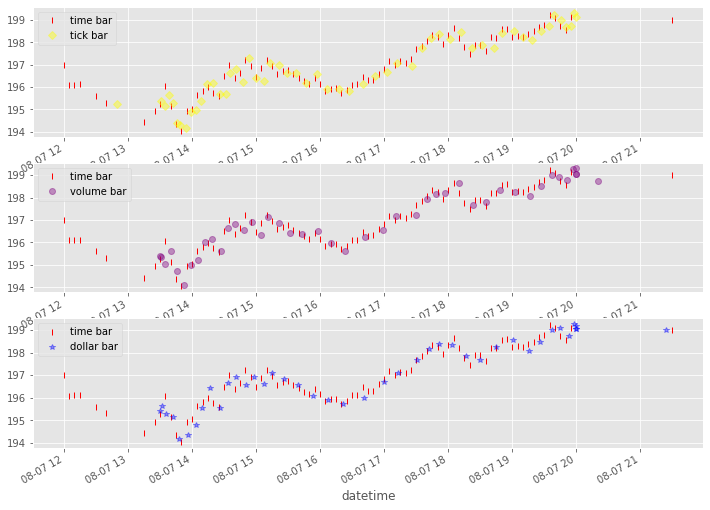

In [6]:
plot_bars(AAPL)

I have randomly choosen a date from the sample and ploted the alternative bars over the time bar as a reference. We can see some clustering at the start and end of the market hours this was expected as more orders are executed during this periods as a result more information is available. But time bar have note captured it due to its constant sampling frequency. 

In [7]:
#Statistical Tests
def get_statistics(bars:dict):
    res = []
    for bar in bars.keys():
        ret = bars[bar].close.pct_change()[1:]
        jb = stats.jarque_bera(ret)[0]
        kurt = stats.kurtosis(ret)
        skew = stats.skew(ret)
        mean = ret.mean()
        std = ret.std()
        res.append([mean, std, skew, kurt, jb])
    return pd.DataFrame(res, index=bars.keys(), columns=['mean', 'std', 'skew', 'kurtosis','jarque-bera stats'])

In [8]:
get_statistics(AAPL)

,mean,std,skew,kurtosis,jarque-bera stats
time_bar_5m,0.000015,0.001868,-1.572689,126.975942,2.748892e+07
tick_bar,0.000028,0.002480,-0.804823,92.320029,7.839625e+06
volume_bar,0.000030,0.002658,-0.748110,96.105390,7.911607e+06
dollar_bar,0.000033,0.002745,-0.585984,79.140205,4.910621e+06


Here we see some important statistics for different bars returns. The dollar bar has the best statistics among all, especially has the lowest Jarque Bera stats and kurtosis. Also, the time bars has least attractive stats among all.

In [9]:
##ACF Plots 
def plot_bar_acf(bars:dict, lags:int=120):
    fig, axes = plt.subplots(2, 2, figsize=(20,15))
    loc = [(0,0), (0,1), (1,0), (1,1)]
    for i, bar in enumerate(bars.keys()):
        ret = bars[bar].close.pct_change()[1:]
        plot_acf(ret, lags=lags, zero=False, ax=axes[loc[i][0],loc[i][1]], title=f'{bar} Auto Correlation with {lags} lag')

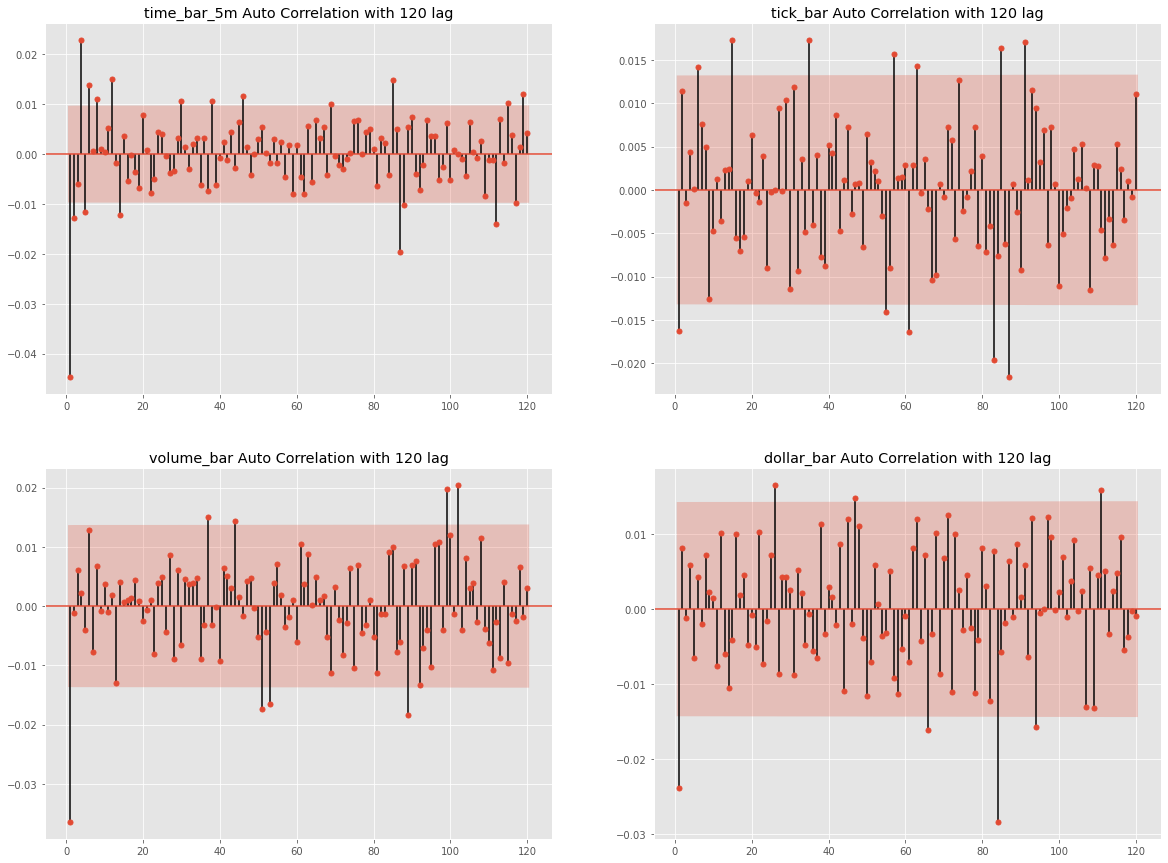

In [10]:
plot_bar_acf(AAPL)

In [11]:
##Serial Correlations/ Auto-Correlations 
def get_auto_corr(bars:dict):
    for bar in bars.keys():
        ret = bars[bar].close.pct_change()[1:]
        auto_corr = ret.autocorr(lag=1)
        print(f'Auto-correlations for {bar} is {auto_corr}')

In [12]:
get_auto_corr(AAPL)

Auto-correlations for time_bar_5m is -0.04471037902066153
Auto-correlations for tick_bar is -0.016266864673144855
Auto-correlations for volume_bar is -0.03644971745586813
Auto-correlations for dollar_bar is -0.023814722652438655


There is no auto-correlation in any of the given bars. 

In [13]:
#Distribution Plot
def plot_return_distributions(bars:dict):
    f,ax=plt.subplots(figsize=(14,10))
    for bar in bars.keys():
        ret = bars[bar].close.pct_change()[1:]
        #normalize the returns 
        norm_ret = (ret - ret.mean()) / ret.std()
        sns.kdeplot(norm_ret, label=bar)
    sns.kdeplot(np.random.normal(size=100000), label="Normal", color='black', linestyle="--")
    plt.xticks(range(-5, 6))
    plt.legend(loc=8, ncol=5)
    plt.xlim(-5, 5)
    plt.show()

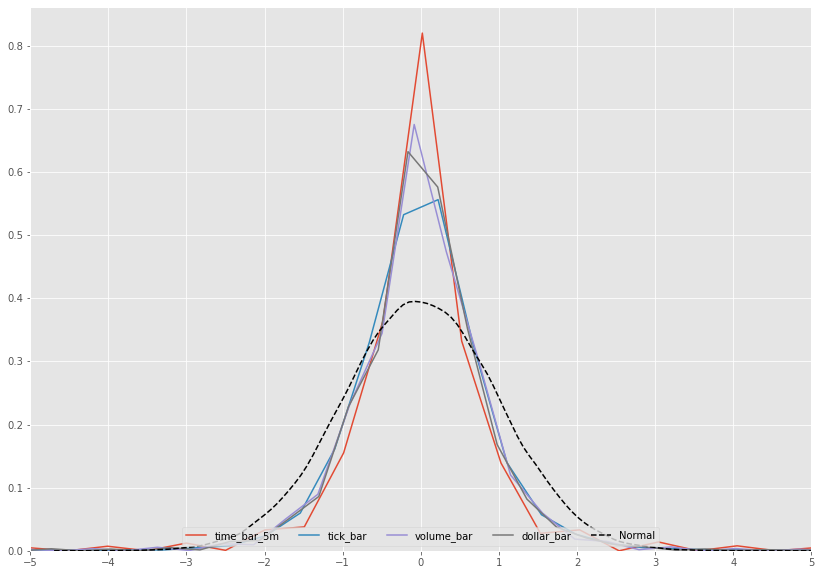

In [14]:
plot_return_distributions(AAPL)

From the above plot we see a partial recovery to normality for the alternative bars comapred to the time bars. The normal distribution is shown with the dotted black line in the above graph. 

## Conclusion

From the above analysis we conclude that alternative bars are promising and has attractive properties compared to time bar. But the only factor that affects the bars is its threshold or sampling frequency, a change threshold can bring significant changes in its properties. For analysis I choose the thresholds arbitarily, which should not be done if it is applied in practice. A good solution is to use dynamic threshold (threshold that keeps changing over time) as a function of a metric that can track market dyanmics. *Dr de Prado* suggested using a function of free-float marketcapitalization of a stock as dynamic threshold. Also, it is not the case that alternative bars always performs better than time bars. Wether to go with time bar or volume bar or dollar bar depends on the problem we are trying to solve, blindly going with any one of those might lead sub-optimal or poor result. A proper statistical tests as shown above should help choosing the right bar for the problem. For example we want to capture the a short-term momentum than we can think using dollar bars and volume bars as the most important factor affecting the short term momentum is trade volume. A second example would explain or capture seasonality is the market, in this case time bar seems obvious. 

**Key Takeaways:** <br>

- Alternatives brs properties are dependent on the threshold used for sampling.
- Use dynamic threshold while applying alternative bars in practice.
- Choosing the right type of bars depends on the problem we are solving. 
- Statistical tests as above might help choosing the right bar for the problem.
- Alternative bars shines well with machine learning model.

Finally, I would like say that feel free playing with this notebook with different securities and compare the results. You may also refer the sources given below - 

- https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/Tick%2C%20Volume%2C%20Dollar%20Volume%20Bars.ipynb
- https://mlfinlab.readthedocs.io/en/latest/implementations/data_structures.html